In [1]:
# ] activate .

In [2]:
]st

Status `~/Dropbox (Lidar group)/Personal/USC/Rigetti/DD/DD_simulations/Project.toml`
  [f67ccb44] HDF5 v0.17.1
  [b964fa9f] LaTeXStrings v1.3.0
  [2fda8390] LsqFit v0.14.0
  [e429f160] OpenQuantumTools v0.7.5
  [1dea7af3] OrdinaryDiffEq v6.57.0
  [91a5bcdd] Plots v1.39.0
  [d330b81b] PyPlot v2.11.2
  [1fd47b50] QuadGK v2.9.1
  [295af30f] Revise v3.5.6
⌅ [2913bbd2] StatsBase v0.33.21
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


## Importing packages

In [3]:
using StatsBase
using Plots
using LaTeXStrings
using Plots.Measures
using Printf
using LsqFit
using LinearAlgebra
using OpenQuantumTools ## HOQST 
using OrdinaryDiffEq
using Revise
using QuadGK

E_CHARGE = 1.602176634e-19
PHI_0  = 2.067833831e-15
H_PLANCK = 6.62607015e-34;

$$H_{\rm tot} = H_{\rm sys} + \delta(t)A_{\rm coupling} $$
where $\delta(t)$ is a sum of telegraph processes given by
$$ \delta(t) = \sum_i^N T_{i}(t).$$

If $T_i(t)$ switches randomly between $\pm b_i$ with rate $\gamma_{i}$, and if $\gamma_{i}s$ are distributed uniform logarithmically from $\gamma_{\rm min}$ to $\gamma_{\rm max}$, in the limit of $N\gg 1$, the noise spectrum of $\delta(t)$ approaches $1/f$ in that interval. Usually we can get this behavior even when $N$ is not very large

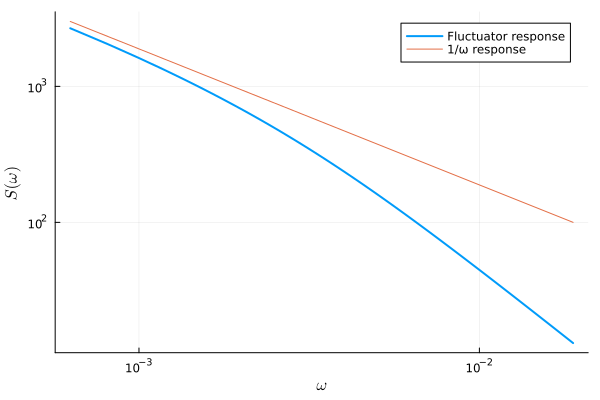

In [4]:
# calculate the mean and standard deviation of the mean estimator from a sample
function mean_std(sample)
    m, v = mean_and_std(sample, corrected=true)
    m, v/sqrt(length(sample))
end

num = 10
bvec = 0.5 * ones(num)
γvec = log_uniform(0.0001, 0.003, num)
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);


## Plotting the noise spectrum due to the fluctuator ensemble
plot(fluctuator_ensemble, :spectrum, 2*π*range(0.0001, 0.003, length=100), xscale=:log10, yscale=:log10, 
    linewidth=2, label="Fluctuator response")

f_list = range(0.0001, 0.003, length=100)
one_f_list = [2/el^1. for el in f_list];
plot!(2*pi*f_list, one_f_list*0.15, label = "1/ω response")

xlabel!(L"\omega")
ylabel!(L"S(\omega)")

In [5]:
v0 = [1.0, 0]
v1 = [0.,1.0]
vp = (v0 + v1)/sqrt(2)
vm = (v0 - v1)/sqrt(2)
vpi = (v0 + 1im*v1)/sqrt(2)
vmi = (v0 - 1im*v1)/sqrt(2)

## Hardware parameters corresponding to transmon qubits

ωq0 = 4.820 ## (in GHz), here it doesn't matter becuase we go into the rotating frame where |+> state is stationary


H_mat = -ωq0*σz/2


## Going into the rotating frame

num_op_trunc = Diagonal([0, 1])
H_mat_trunc = H_mat - H_mat[1,1]*Diagonal([1 for i = 1:2])
ωd = ωq0  ## Choosing the drive to be on resonance with the qubit frequency
H_rotated = H_mat_trunc - ωd * num_op_trunc
real(H_rotated)

2×2 Matrix{Float64}:
  0.0  -0.0
 -0.0   0.0

## Simulating the free evolution experiment under 1/f noise

In [6]:
v_in = vpi
tf = 600 ## ns
npoints = 600
H = DenseHamiltonian([(s) -> 1.0], [H_rotated], unit=:h)
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);
coupling = ConstantCouplings([0.0003*σz])
annealing = Annealing(H, v_in, coupling = coupling, bath=fluctuator_ensemble)

prob = build_ensembles(annealing, tf, :stochastic)
# we run each trajectory serially for this example
@time sol = solve(prob, Tsit5(), EnsembleSerial(), trajectories=100, reltol=1e-8, saveat=range(0,tf,length=npoints));

  2.541079 seconds (9.06 M allocations: 557.269 MiB, 5.35% gc time, 94.13% compilation time)


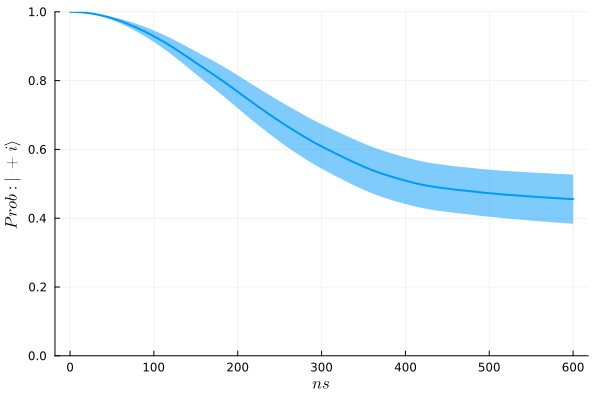

In [7]:
t_axis = range(0,tf,length=npoints)
es = []
err = []
for (i, s) in enumerate(t_axis)
    sample = [abs2(v_in'*so[i]) for so in sol]
    pop, pop_std = mean_std(sample)
    push!(es, pop)
    push!(err, 2*pop_std)
end

plot(t_axis, es, ribbon=err, linewidth=2, label="")
xlabel!(L"ns")
ylabel!(L"Prob: |+i\rangle")
ylims!(0,1)

## Saving the density matrices and populations for each of the trajectories

In [8]:
rho_all_traj_list = []
pop_all_traj_list = []
rho_sample = nothing
for (j,traj) in enumerate(sol)
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list, rho_sample_list)
    push!(pop_all_traj_list, sample_pop_list)
end

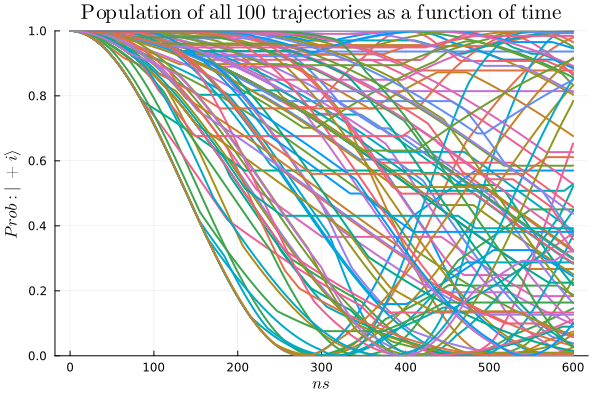

In [9]:
plot(t_axis, pop_all_traj_list,  linewidth=2, label="")
ylabel!(L"Prob: |+i\rangle")
xlabel!(L"ns")
title!(L"$\textrm{Population~ of~ all~ 100~ trajectories ~as ~a ~function~ of ~time}$")
ylims!(0,1)

## With instant dynamical decoupling pulses

In [10]:
n_reps_list  = [0.5] ## Using 0.5 because 1 represents 4 pulses but we only want to have two X pulses here

exp_DD_list = []
err_DD_list = []

sol_DD_list = nothing

for (idx, n_reps) in enumerate(n_reps_list)
    
    pulse_timimg_list   = [(2*i-1)/2/4/n_reps for i in 1:4*n_reps] ## This is for finding positions for 4 pulses
    
    cb = InstPulseCallback(pulse_timimg_list.* tf, (c, x) -> c .= σx * c)
    annealing = Annealing(H, v_in, coupling = coupling, bath=fluctuator_ensemble)
    prob = build_ensembles(annealing, tf, :stochastic)
    
    @time sol_DD_list = solve(prob, Tsit5(), EnsembleSerial(), trajectories=100, reltol=1e-8, 
        tstops=range(0,tf,length=npoints), saveat=range(0,tf,length=npoints), callback=cb);
    
    exp_DD = []
    err_DD = []
    for (i, s) in enumerate(t_axis)
        sample = [abs2(v_in'*so[i]) for so in sol_DD_list]
        pop, pop_std = mean_std(sample)
        push!(exp_DD, pop)
        push!(err_DD, 2*pop_std)
    end
    push!(exp_DD_list, exp_DD)
    push!(err_DD_list, err_DD)
end

  1.880718 seconds (12.16 M allocations: 594.961 MiB, 6.44% gc time, 60.48% compilation time)


In [11]:
rho_all_traj_list_XX = []
pop_all_traj_list_XX = []
rho_sample = nothing
for (j,traj) in enumerate(sol_DD_list)
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list_XX, rho_sample_list)
    push!(pop_all_traj_list_XX, sample_pop_list)
end

In [12]:
using HDF5

function save_vector_to_group(file, vector_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(vector_data)
        matrix_data = hcat(vector_data[i]...)
        write(g, "dataset_$i", matrix_data)
    end
end

function save_list_to_group(file, list_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(list_data)
        write(g, "dataset_$i", list_data[i])
    end
end

h5open("./data/rho_init_plus_i_DD_XX_under_1f_case_1.h5", "w") do file
    save_vector_to_group(file, rho_all_traj_list, "free")
    save_vector_to_group(file, rho_all_traj_list_XX, "XX")
    save_list_to_group(file, collect(t_axis), "time")
end


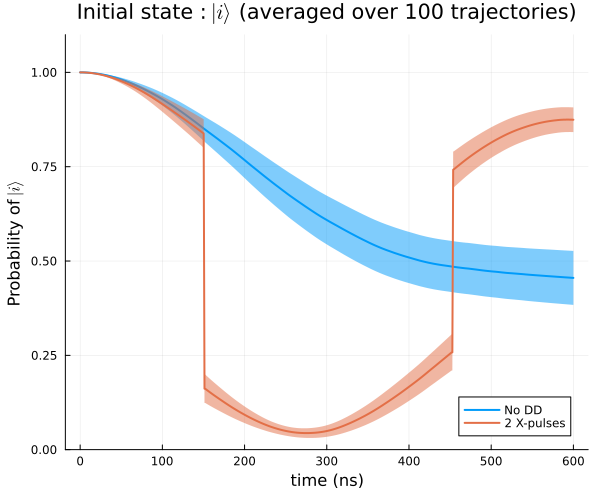

In [13]:
using Plots
using LaTeXStrings
plot(t_axis, es, ribbon=err, linewidth=2, label="No DD", legend=:bottomright)
plot!(t_axis, exp_DD_list[1], ribbon=err_DD_list[1], linewidth=2, label="2 X-pulses")

ylims!(0.,1.1)
xlabel!("time (ns)")

ylabel!(L"Probability of $|i\rangle$")
title!(L"Initial state : $|i\rangle$ (averaged over 100 trajectories)")
plot!(size=(600,500))

Note: Here, with XX pulses, we see that there is not a complete suppression of noise in the above plot. If we now repeat the whole simulation with maximum frequency of the fluctuators reduced significantly, we will notice that the suppression is almost perfect. This is related to the concept of DD where DD repetition rate should be greater than the cut-off frequency of the bath.

## Repeating again with lower value of maximum fluctuator frequency

### Free evolution

In [14]:
num = 10
bvec = 0.5 * ones(num)
γvec = log_uniform(0.0001, 0.0003, num)
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);

v_in = vpi
tf = 600 ## ns
npoints = 600
H = DenseHamiltonian([(s) -> 1.0], [H_rotated], unit=:h)
fluctuator_ensemble = EnsembleFluctuator(bvec, γvec);
coupling = ConstantCouplings([0.0003*σz])
annealing = Annealing(H, v_in, coupling = coupling, bath=fluctuator_ensemble)

prob = build_ensembles(annealing, tf, :stochastic)
# we run each trajectory serially for this example
@time sol = solve(prob, Tsit5(), EnsembleSerial(), trajectories=100, reltol=1e-8, saveat=range(0,tf,length=npoints));


rho_all_traj_list = []
pop_all_traj_list = []
rho_sample = nothing
for (j,traj) in enumerate(sol)
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list, rho_sample_list)
    push!(pop_all_traj_list, sample_pop_list)
end

  0.046899 seconds (580.64 k allocations: 30.878 MiB, 10.45% compilation time)


### DD evolution

In [15]:
n_reps_list  = [0.5] ## Using 0.5 because 1 represents 4 pulses but we only want to have two X pulses here

exp_DD_list = []
err_DD_list = []

sol_DD_list = nothing

for (idx, n_reps) in enumerate(n_reps_list)
    
    pulse_timimg_list   = [(2*i-1)/2/4/n_reps for i in 1:4*n_reps] ## This is for finding positions for 4 pulses
    
    cb = InstPulseCallback(pulse_timimg_list.* tf, (c, x) -> c .= σx * c)
    annealing = Annealing(H, v_in, coupling = coupling, bath=fluctuator_ensemble)
    prob = build_ensembles(annealing, tf, :stochastic)
    
    @time sol_DD_list = solve(prob, Tsit5(), EnsembleSerial(), trajectories=100, reltol=1e-8, 
        tstops=range(0,tf,length=npoints), saveat=range(0,tf,length=npoints), callback=cb);
    
    exp_DD = []
    err_DD = []
    for (i, s) in enumerate(t_axis)
        sample = [abs2(v_in'*so[i]) for so in sol_DD_list]
        pop, pop_std = mean_std(sample)
        push!(exp_DD, pop)
        push!(err_DD, 2*pop_std)
    end
    push!(exp_DD_list, exp_DD)
    push!(err_DD_list, err_DD)
end
rho_all_traj_list_XX = []
pop_all_traj_list_XX = []
rho_sample = nothing
for (j,traj) in enumerate(sol_DD_list)
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list_XX, rho_sample_list)
    push!(pop_all_traj_list_XX, sample_pop_list)
end

  1.784057 seconds (11.42 M allocations: 553.488 MiB, 5.77% gc time, 59.49% compilation time)


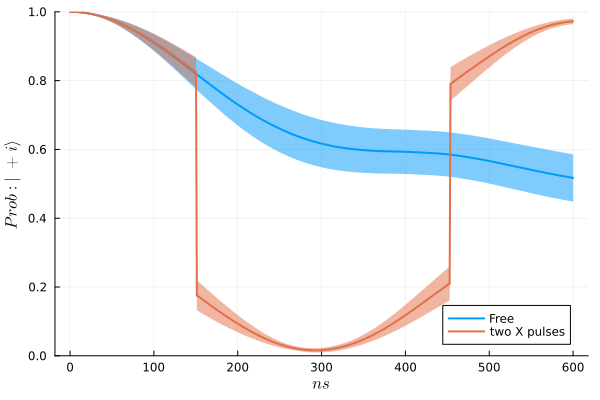

In [16]:
es = []
err = []
es_XX = []
err_XX = []
for (i, s) in enumerate(t_axis)
    sample = [abs2(v_in'*so[i]) for so in sol]
    pop, pop_std = mean_std(sample)
    push!(es, pop)
    push!(err, 2*pop_std)
    
    sample = [abs2(v_in'*so[i]) for so in sol_DD_list]
    pop, pop_std = mean_std(sample)
    push!(es_XX, pop)
    push!(err_XX, 2*pop_std)
end

plot(t_axis, es, ribbon=err, linewidth=2, label="Free")
plot!(t_axis, es_XX, ribbon=err_XX, linewidth=2, label="two X pulses")
xlabel!(L"ns")
ylabel!(L"Prob: |+i\rangle")
ylims!(0,1)

Now we see that the suppression with 2 X pulses is much more efficient

In [17]:
using HDF5

function save_vector_to_group(file, vector_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(vector_data)
        matrix_data = hcat(vector_data[i]...)
        write(g, "dataset_$i", matrix_data)
    end
end

function save_list_to_group(file, list_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(list_data)
        write(g, "dataset_$i", list_data[i])
    end
end

h5open("./data/rho_init_plus_i_DD_XX_under_1f_case_2.h5", "w") do file
    save_vector_to_group(file, rho_all_traj_list, "free")
    save_vector_to_group(file, rho_all_traj_list_XX, "XX")
    save_list_to_group(file, collect(t_axis), "time")
end


## Time-dependent pulses

Instant pulses are only an assumption and in reality these have some width. Here we model them as time-dependent microwave pulses with fast oscillating drive frequency and a gaussian pulse. By going into the rotating frame of the drive, which is applied on resonance with the qubit frequency, we are left with only the envelope which is gaussian in nature.

Let us define some simple functions and repeat the DD simulations from above

In [18]:
function pulse(x,σ, x_centre, Ω_val, tg_val)
    σ1_val = tg_val/6
    if x<=(x_centre-3σ) || x>=(x_centre+3σ)
        ans = 0
        else 
        ans=  Ω_val*(exp(-(x-x_centre)^2/2/σ^2)-exp(-tg_val^2/8/σ1_val^2))    ## Here I have used actual tg and and σ1 because
                                                                 ##  their ratio is not affected
    end
    return ans
end


function pulse_center_list(n_pulse)
    return [(2*i-1)/2/n_pulse for i in 1:n_pulse]
end

function build_pulse_funcs(seq, σ_norm, tf_tot, Ω_val, tg_val)
    list0 = [(s)->1]
    list1 = [(s)->pulse(s, σ_norm, pos, Ω_val, tg_val) for pos in seq]
    vcat(list0, list1)
end

build_pulse_funcs (generic function with 1 method)

In [19]:
tot_n = 2
a_dagger = Bidiagonal(zeros(Float64,tot_n), [sqrt(i)*(1) for i = 1:tot_n-1], :L)
a = Transpose(a_dagger)
H_x_temp = (a + a_dagger)./2
H_y_temp = 1im*(-a + a_dagger)./2
N_hat = Diagonal([i-1 for i = 1:tot_n])

H_z_temp = (a_dagger*a)-Matrix(I,2,2)/2

axis_error = 0*pi/180
"""Adding errors to the axis of rotation for X and Y gates"""
H_x = cos(axis_error)*H_x_temp + sin(axis_error)*H_y_temp
H_y = cos(axis_error)*H_y_temp - sin(axis_error)*H_x_temp

2×2 Matrix{ComplexF64}:
 0.0+0.0im  -0.0-0.5im
 0.0+0.5im   0.0+0.0im

In [20]:
## -X--X- where - is [tau] free evo. and each of the gates X or Y are 2 tau long i.e. len(X) = len(--)
function cpmg(n_reps, Ω_val, tg_val ,tau_factor)
    tf_tot = n_reps*2*tau_factor*tg_val
    σ_norm = tg_val/6/tf_tot
    
    H_mats = [Complex.(H_rotated)]
    for i in 1:n_reps
        push!(H_mats, H_x)
        push!(H_mats, H_x)
    end

    centers = [(2*i-1)/2/(2*n_reps) for i in 1:(2*n_reps)]
    println(centers)
    Ham = DenseHamiltonian(build_pulse_funcs(centers, σ_norm,tf_tot, Ω_val, tg_val), H_mats)
    return Ham, tf_tot
end

cpmg (generic function with 1 method)

In [21]:
using QuadGK
tg = 20 ## ns (gate time)
deviation = 0
angle_required = pi+deviation*pi/180
Rot_angle = quadgk((x)->2*pi*1*(exp(-(x-tg/2)^2/2/(tg/6)^2)- exp(-tg^2/8/(tg/6)^2)), 0, tg, rtol=1e-8)
Ω = angle_required/Rot_angle[1]

0.06164703846922896

In [22]:
n_seq = 0.5
τ_factor = 15
H_XX,tf_XX = cpmg(2*n_seq, Ω, tg, τ_factor)
println(tf_XX)

v_in = vpi
tf = tf_XX

## Simulating the free evolution again

H = DenseHamiltonian([(s) -> 1.0], [H_rotated], unit=:h)
coupling = ConstantCouplings([0.0003*σz])
annealing = Annealing(H, v_in, coupling = coupling, bath=fluctuator_ensemble)

prob = build_ensembles(annealing, tf, :stochastic)

# we run each trajectory serially for this example
@time sol = solve(prob, Tsit5(), EnsembleSerial(), trajectories=100, reltol=1e-8, 
    tstops=range(0,tf,length=npoints),saveat=range(0,tf,length=npoints));


[0.25, 0.75]
600.0
  1.312589 seconds (10.46 M allocations: 488.529 MiB, 6.64% gc time, 43.31% compilation time)


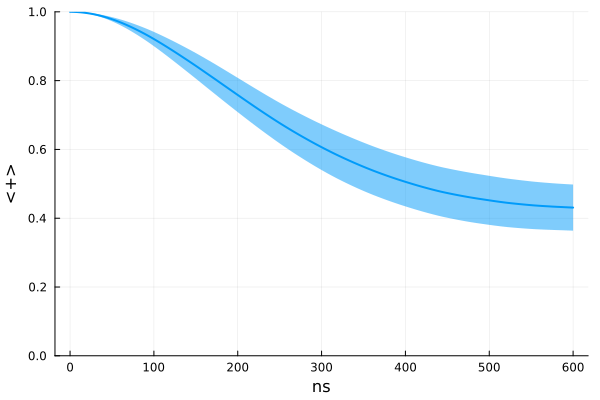

In [23]:
t_axis = range(0,tf,length=npoints)
es = []
err = []
rho_t_list = []
for (i, s) in enumerate(t_axis)
    sample = [abs2(v_in'*so[i]) for so in sol]
    rho_t = [so[i] for so in sol]
    push!(rho_t_list, rho_t)
    pop, pop_std = mean_std(sample)
    push!(es, pop)
    push!(err, 2*pop_std)
end

plot(t_axis, es, ribbon=err, linewidth=2, label="")
xlabel!("ns")
ylabel!("<+>")
ylims!(0,1)

### Simulating the DD evolution using time-dependent gates

In [24]:
v_in = vpi
tf = tf_XX
H = H_XX
coupling = ConstantCouplings([0.0003*σz])
annealing = Annealing(H, v_in, coupling = coupling, bath=fluctuator_ensemble)
prob = build_ensembles(annealing, tf, :stochastic)

# we run each trajectory serially for this example
@time sol_DD = solve(prob, Tsit5(), EnsembleSerial(), trajectories=100, reltol=1e-8, 
    tstops=range(0,tf,length=npoints),saveat=range(0,tf,length=npoints));


  0.941845 seconds (11.52 M allocations: 473.443 MiB, 8.52% gc time, 4.71% compilation time)


In [25]:
exp_DD_list = []
err_DD_list = []
for (i, s) in enumerate(t_axis)
    sample = [abs2(v_in'*so[i]) for so in sol_DD]
    pop, pop_std = mean_std(sample)
    push!(exp_DD_list, pop)
    push!(err_DD_list, 2*pop_std)
end

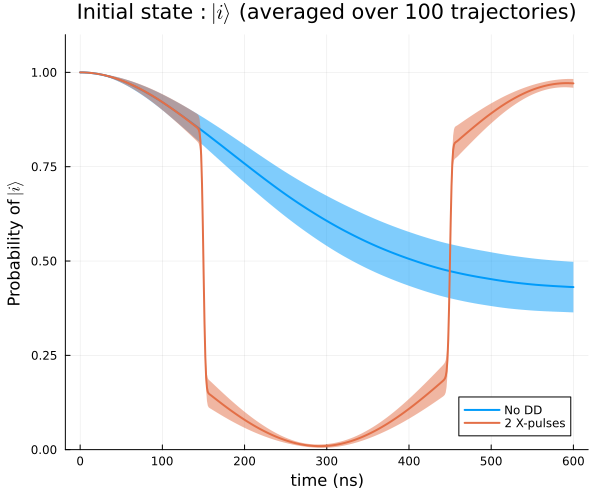

In [26]:
using Plots
using LaTeXStrings
plot(t_axis, es, ribbon=err, linewidth=2, label="No DD", legend=:bottomright)
plot!(t_axis, exp_DD_list, ribbon=err_DD_list, linewidth=2, label="2 X-pulses")


ylims!(0.,1.1)
xlabel!("time (ns)")

ylabel!(L"Probability of $|i\rangle$")
title!(L"Initial state : $|i\rangle$ (averaged over 100 trajectories)")
plot!(size=(600,500))

In [27]:
rho_all_traj_list = []
pop_all_traj_list = []
rho_sample = nothing
for (j,traj) in enumerate(sol)
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list, rho_sample_list)
    push!(pop_all_traj_list, sample_pop_list)
end

rho_all_traj_list_XX = []
pop_all_traj_list_XX = []
traj1 = nothing
rho_sample = nothing
for (j,traj) in enumerate(sol_DD)
    traj1 = traj
    rho_sample_list = []
    sample_pop_list = []
    for (i, s) in enumerate(t_axis)
        rho_sample = traj[i]
        sample_pop = abs2(v_in'*rho_sample)
        push!(sample_pop_list, sample_pop)
        push!(rho_sample_list, rho_sample)
    end
    push!(rho_all_traj_list_XX, rho_sample_list)
    push!(pop_all_traj_list_XX, sample_pop_list)
end

using HDF5

function save_vector_to_group(file, vector_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(vector_data)
        matrix_data = hcat(vector_data[i]...)
        write(g, "dataset_$i", matrix_data)
    end
end

function save_list_to_group(file, list_data, groupname)
    g = create_group(file, groupname)
    for i in 1:length(list_data)
        write(g, "dataset_$i", list_data[i])
    end
end

h5open("./data/rho_init_plus_i_DD_time_dependent_XX_under_1f_case_2.h5", "w") do file
    save_vector_to_group(file, rho_all_traj_list, "free")
    save_vector_to_group(file, rho_all_traj_list_XX, "XX")
    save_list_to_group(file, collect(t_axis), "time")
end